# Design Project -- Circuit Component Classification

Ray Mohabir
<br>
Professor Campisi
<br>
Date: 5/16/2018

# Problem

Using image recognition, is it possible to identify different circuit components correctly?
<br>
What I want to accomplish:
    1. Gather a large enough sample size for training and testing
    2. Construct a neural network architecture
    3. Run the samples through the neural network
    4. Develop a bounding box on every image for location purposes

# Credits to:

Nnamdi P Nwaokorie -- [Allowing me to use his samples after dreading to draw them and for some code for the bounding box](https://github.com/npn225/Intro-to-Machine-Learning-Circuit-Component-Identification-Project/tree/master/Electronics/Img)

# Initializer

In [18]:
from PIL import Image
import numpy as np
import pandas as pd
import skimage.io
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import os
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imshow

In [19]:
# We have the following mapping: {Dependent_Voltage_Source : Sample001, Independent_Voltage_Source : Sample002,
#                                 Dependent_Current_Source : Sample003, Independent_Current_Source : Sample004, 
#                                 Resistor : Sample005}

file_names = ["Sample001","Sample002","Sample003","Sample004","Sample005"]
tmp_files = ["Sample001_scaled", "Sample002_scaled","Sample003_scaled","Sample004_scaled","Sample005_scaled"]
titles = ["Dependent Voltage Source", "Independent Voltage Source", "Dependent Current Source"
         ,"Independent Current Source", "Resistor"]
# Use one hot encoding the map the true results
encoded_arr = [np.array([1,0,0,0,0]),np.array([0,1,0,0,0]),np.array([0,0,1,0,0]),np.array([0,0,0,1,0]) ,np.array([0,0,0,0,1])]
num_classes = len(file_names)

# Resizing and Converting Images

Need to resize all of the images to the same size so we can work with it later on. I decided to resize it to (100,100) instead of MNIST standard (28,28) because I want to keep the quality of the pictures so that when we run a CNN, we can grab the features better. However, the larger the image size, the slower the CNN will be. So we are trading performance speed with accuracy.

We are also going to convert the images into a numpy array so that we can use neural networks later on.

In [20]:
def resizeAndConvertImages(path_name):
    # Resize images to (100,100) and convert the images to a numpy array to work with later on.
    
    # Get a list of  the files and create new files if they do not already exist
    paths = os.listdir(path_name)
    new_path = path_name+"_scaled"
    if (os.path.exists(new_path)== False):
        os.mkdir(new_path) 
    
    # Iterate through the folders and resize all of images in each folder to (100,100)
    # then append it to a tmp_arr as a numpy array with dtype = int
    tmp_arr = []
    for files in paths:
        if os.path.isfile(path_name+'/'+files):
            image = Image.open(path_name+'/'+ files)
            image = image.resize((100,100),Image.ANTIALIAS)
            final_path = new_path+'/'+files+'_scaled'
            image.save(final_path+'.JPG',optimize=True,quality=95)
            tmp_arr.append(np.asarray(image,dtype=int))
        else:
            print("error resizing: "+new_path)
       
    return tmp_arr

In [21]:
image_arr = []
for files in file_names:
    image_arr.append(resizeAndConvertImages(files))

In [22]:
# image_arr = []
# for files in tmp_files:
#     image_arr.append(files)

In [23]:
total_num_images = len(image_arr[0])*len(file_names)
x = np.zeros((total_num_images,100,100,3))
y = np.zeros((total_num_images,num_classes))
print(x.shape)

(8000, 100, 100, 3)


Since the image_arr is already sorted based on samples, we will use the encoded array to map the true values to y

In [24]:
counter = 0
for files in range(len(file_names)):
    for image in range(len(image_arr[files])):
        x[counter, :, :, :] = image_arr[files][image]
        y[counter, :] = encoded_arr[files]
        counter += 1
print(y)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


Now we need to split our data into training data and testing data. We are going to do the 70/30 model, where we train on 70% of the dataset and test on 30%. Due to how we inputted our data, we need to shuffle it around so that the neural network doesn't memorize the data.

In [25]:
from sklearn.model_selection import train_test_split

x_tr,x_tst,y_tr,y_tst = train_test_split(x,y,test_size=0.3,random_state=42,shuffle=True)

In [26]:
print(x_tr[0])
print(y_tr[0])

[[[165. 137. 113.]
  [165. 137. 113.]
  [165. 137. 113.]
  ...
  [169. 143. 120.]
  [169. 143. 120.]
  [169. 143. 120.]]

 [[163. 135. 111.]
  [163. 135. 111.]
  [164. 136. 112.]
  ...
  [169. 143. 120.]
  [169. 143. 120.]
  [169. 143. 120.]]

 [[163. 135. 111.]
  [163. 135. 111.]
  [163. 135. 111.]
  ...
  [169. 143. 120.]
  [169. 143. 120.]
  [169. 143. 120.]]

 ...

 [[165. 137. 113.]
  [165. 137. 113.]
  [164. 136. 112.]
  ...
  [169. 142. 121.]
  [169. 142. 121.]
  [169. 142. 121.]]

 [[163. 135. 111.]
  [163. 135. 111.]
  [164. 136. 112.]
  ...
  [170. 143. 122.]
  [170. 143. 122.]
  [170. 143. 122.]]

 [[165. 137. 113.]
  [165. 137. 113.]
  [165. 137. 113.]
  ...
  [171. 144. 123.]
  [171. 144. 123.]
  [171. 144. 123.]]]
[0. 0. 0. 0. 1.]


On the cell above, for the first training image, we are expecting it to be a resistor

# Neural Network Training

In [27]:
import keras
from keras import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
import keras.backend as k
import tensorflow as tf

In [28]:
k.clear_session()
num_epoch = 20
batch_size = 100

The following IoU code was adapted from [agoltero](https://www.kaggle.com/aglotero/another-iou-metric) who implemented IoU metrics for a Kaggle Competition

In [29]:
def acc_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        true_negatives = np.sum(matches,axis=0) == 1 
        tp, fp, fn, tn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives), np.sum(true_negatives)
        return tp, fp, fn, tn

In [30]:
from skimage.morphology import label

def iou(y_true, y_pred, print_table=False):
    # Setting threshold to 0.5.
    labels = label(y_true > 0.5)
    ypred = label(y_pred > 0.5)
    
    num_true = len(np.unique(labels))
    num_pred = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), ypred.flatten(), bins=(num_true,num_pred))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = num_true)[0]
    area_pred = np.histogram(y_pred, bins = num_pred)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    
    iou = intersection/union
    
    acc = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn, tn = acc_at(t, iou)
        if (tp + fp + fn + tn) > 0:
            p = (tp + tn) / (tp + fp + fn + tn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        acc.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(acc)))
    return np.mean(acc)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

We are going to use the ReLU activation function because it is the most popular at the moment and we are able to train the network much faster. Due to the number of layers we will have, this is very important.

Conv2D is typically used for this type of training. Conv2D is spatial convolution over 2D images.

We use batch normalization so that every input gets normalized (speeds up runtime), reduces overfitting, and makes sure the activation doesn't get crazy small or crazy large.

Max Pooling grabs the more important features.

In [31]:
model = Sequential()
model.add(Conv2D(32, input_shape=x_tr[0].shape, activation='relu', kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, activation='relu', kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, activation='relu', kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Conv2D(64, activation='relu', kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, activation='relu', kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax', name = 'output'))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        36928     
__________

We want to keep track of accuracy, loss, and iou data per epoch. Thus, we use keras callbacks to grab that information after model fitting.

In [33]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.val_loss = []
        self.val_acc = []
        self.acc = []
       # self.iou_metric = []
       # self.val_iou_metric = []
        
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        self.val_loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
      #  self.iou_metric(logs.get('iou_metric'))
      #  self.val_iou_metric(logs.get('val_iou_metric'))
        
# Create an instance of the history callback
history_cb = LossHistory()

In [34]:
from keras import optimizers
opt = optimizers.Adadelta(lr=0.01) # leaving remaining parameters as default
# model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy","mse",iou_metric])
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])

In [35]:
model.fit(x_tr,y_tr, epochs=num_epoch, batch_size=batch_size, validation_data=(x_tst, y_tst), callbacks=[history_cb])

Train on 5600 samples, validate on 2400 samples
Epoch 1/20
5600/5600 [==============================] - 354s 63ms/step - loss: 1.5507 - acc: 0.4045 - val_loss: 1.1876 - val_acc: 0.5396
Epoch 2/20
5600/5600 [==============================] - 334s 60ms/step - loss: 0.9304 - acc: 0.6434 - val_loss: 0.8838 - val_acc: 0.6908
Epoch 3/20
5600/5600 [==============================] - 327s 58ms/step - loss: 0.6525 - acc: 0.7770 - val_loss: 0.7093 - val_acc: 0.7596
Epoch 4/20
5600/5600 [==============================] - 327s 58ms/step - loss: 0.4911 - acc: 0.8355 - val_loss: 0.6046 - val_acc: 0.8004
Epoch 5/20
5600/5600 [==============================] - 327s 58ms/step - loss: 0.3864 - acc: 0.8796 - val_loss: 0.5248 - val_acc: 0.8296
Epoch 6/20
5600/5600 [==============================] - 326s 58ms/step - loss: 0.3017 - acc: 0.9150 - val_loss: 0.4654 - val_acc: 0.8488
Epoch 7/20
5600/5600 [==============================] - 328s 59ms/step - loss: 0.2482 - acc: 0.9334 - val_loss: 0.4137 - val_acc: 

We are going to save the model so we can use it again if we want to at a later time

In [36]:
model.save("cnn_electronic_components_dp2_v9.h5")

Let's look at the data from running the neural network

In [37]:
model = keras.models.load_model("cnn_electronic_components_dp2_v9.h5")

In [38]:
epochs = np.arange(1,num_epoch+1)
print(len(history_cb.val_acc))
print(len(history_cb.val_loss))
print(len(history_cb.val_loss)/num_epoch)

20
1120
56.0


In [39]:
loss_tmp = []
for i in range(len(epochs)):
    loss_tmp.append(history_cb.val_loss[i*56])

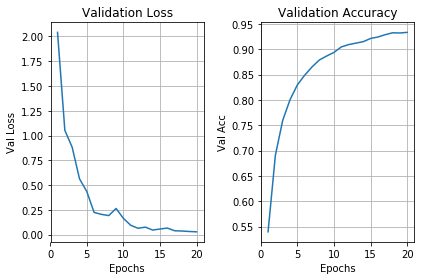

In [40]:
plt.subplot(1,2,1)
plt.title("Validation Loss")
plt.plot(epochs,loss_tmp)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Val Loss")
plt.subplot(1,2,2)
plt.title("Validation Accuracy")
plt.plot(epochs,history_cb.val_acc)
plt.xlabel("Epochs")
plt.ylabel("Val Acc")
plt.grid()
# plt.plot(epochs,history_cb.val_iou_metric)
# plt.xlabel("Epochs")
# plt.ylabel("Val IoU")
# plt.grid()
plt.tight_layout()
plt.show()

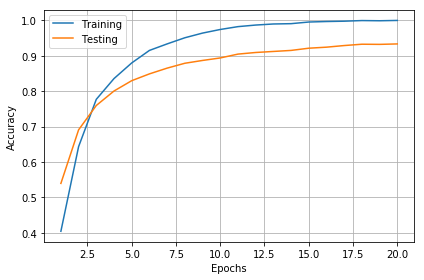

In [52]:
# plt.subplot(1,2,1)
# plt.plot(epochs,history_cb.loss,epochs,history_cb.val_loss)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(["Training","Testing"])
# plt.grid()
#plt.subplot(1,2,2)
plt.plot(epochs,history_cb.acc,epochs,history_cb.val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training","Testing"])
plt.grid()
# plt.subplot(3,1,3)
# plt.plot(epochs,history_cb.iou_metric,epochs,history_cb.val_iou_metric)
# plt.xlabel("Epoch")
# plt.ylabel("IoU")
# plt.legend(["Training","Testing"])
# plt.grid()
plt.tight_layout()
plt.show()

In [42]:
pred_y = model.predict(x_tst, verbose=1)

2400/2400 [==============================] - 45s 19ms/step


In [43]:
print(pred_y[1])
print(encoded_arr[1])
print(np.isclose(encoded_arr[1],pred_y[1],rtol=1e-5,atol=1e-2))
print(pred_y[2])
print(pred_y[3])
t = np.isclose(encoded_arr[1],pred_y[1],rtol=1e-5,atol=1e-2)
if (t.all() == True):
    print("a")

[4.0240223e-03 9.8792368e-01 5.7024672e-04 6.3788607e-03 1.1031857e-03]
[0 1 0 0 0]
[ True False  True  True  True]
[3.5715909e-04 9.9704093e-01 5.4211241e-06 1.2042177e-03 1.3921729e-03]
[6.9022056e-04 9.9639612e-01 2.2516265e-03 5.7436182e-04 8.7601184e-05]


In [44]:
mapped_arr = {"Dependent Voltage Source": encoded_arr[0], "Independent Voltage Source": encoded_arr[1],
              "Dependent Current Source": encoded_arr[2], "Independent Current Source": encoded_arr[3],
              "Resistor": encoded_arr[4]}
y_tst = y_tst.astype(int)

In [45]:
results = np.zeros((len(pred_y),3),dtype="O")
for i in range(len(pred_y)):
    tmp = 'NULL'
    if (np.array_equal(y_tst[i],encoded_arr[0])):
        tmp = "Dependent Voltage Source"
        results[i][1] = encoded_arr[0]
    elif (np.array_equal(y_tst[i],encoded_arr[1])):
        tmp = "Independent Voltage Source"
        results[i][1] = encoded_arr[1]
    elif (np.array_equal(y_tst[i],encoded_arr[2])):
        tmp = "Dependent Current Source"
        results[i][1] = encoded_arr[2]
    elif (np.array_equal(y_tst[i], encoded_arr[3])):
        tmp = "Independent Current Source"
        results[i][1] = encoded_arr[3]
    elif (np.array_equal(y_tst[i],encoded_arr[4])):
        tmp = "Resistor"
        results[i][1] = encoded_arr[4]   
    results[i][0] = tmp    
    results[i][2] = pred_y[i]

In [46]:
def arr_filled(results, identifier):
    true_arr = []
    false_arr = []
    for i in range(len(results)):
        if (results[i][0] == identifier):
            t = np.isclose(mapped_arr[results[i][0]] ,results[i][2],rtol=1e-5,atol=0.25)
            if (t.all() == True):
                true_arr.append(results[i])
            else:
                false_arr.append(results[i])
    return true_arr, false_arr

In [47]:
d_vs_t, d_vs_f = arr_filled(results,"Dependent Voltage Source")
i_vs_t, i_vs_f = arr_filled(results,"Independent Voltage Source")
d_cs_t, d_cs_f = arr_filled(results,"Dependent Current Source")
i_cs_t, i_cs_f = arr_filled(results,"Independent Current Source")
r_t, r_f = arr_filled(results, "Resistor")

In [48]:
print("Dependent Voltage Source: ACC: ", (len(d_vs_t)/(len(d_vs_t)+len(d_vs_f))))
print("Independent Voltage Source: ACC: ",(len(i_vs_t)/(len(i_vs_t)+len(i_vs_f))))
print("Dependent Current Source: ACC: ", (len(d_cs_t)/(len(d_cs_t)+len(d_cs_f))))
print("Independent Current Source: ACC: ", (len(i_cs_t)/(len(i_cs_t)+len(i_cs_f))))
print("Resistor: ACC: ",(len(r_t)/(len(r_t)+len(r_f))))

Dependent Voltage Source: ACC:  0.8891013384321224
Independent Voltage Source: ACC:  0.8463157894736842
Dependent Current Source: ACC:  0.8366890380313199
Independent Current Source: ACC:  0.8113207547169812
Resistor: ACC:  0.9539748953974896


Code adapted from [sklearn examples](http://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)

In [53]:
def plot_images(images, titles, num_row = 5, num_col = 5):
    plt.figure(figsize = (2.5*num_col, 2.5*num_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(num_row * num_col):
        plt.subplot(num_row,num_col,i+1)
        plt.imshow(images[i])
        plt.title(titles[i], size=8)

def get_titles(pred, true,i):
    for j in range(len(encoded_arr)):
        if(np.allclose(encoded_arr[j],pred[i],rtol=1e-5,atol=0.25)):
            pred_name = titles[j]
            break;
        else:
            pred_name = "NULL"
        
    true_name = true[i][0]
    return 'predicted: %s\ntrue: %s' % (pred_name, true_name)

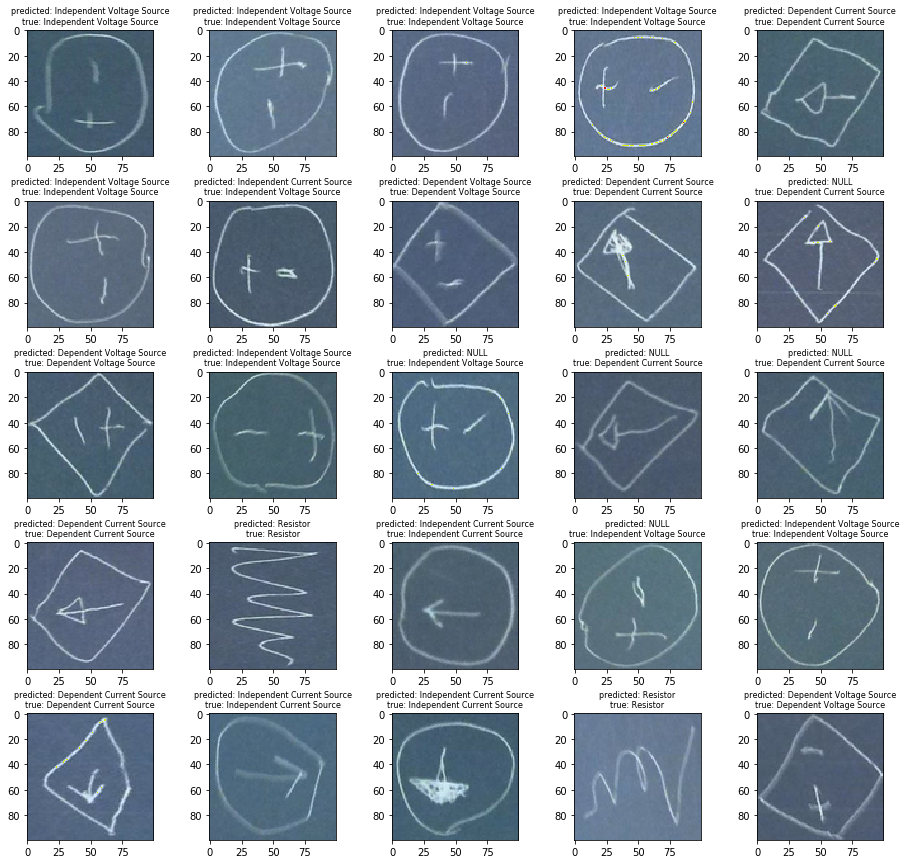

In [50]:
predicted_titles = []
for i in range(len(pred_y)):
    predicted_titles.append(get_titles(pred_y,results,i))
plot_images(x_tst,predicted_titles)

# Conclusion

Unfortunately, I was not able to figure out the bounding box issue.

Using a complex Convolutional Neural Network (CNN), we are able to get a validation accuracy of about 93.33%. If the neural network was ran at a higher number of epochs, the validation accuracy will improve, but there might be overfitting occuring.

Based on the graph above, we can see that the training accuracy converges to 100%, while the testing accuracy coverges to 93.33%. 

Improvements can be made to the neural network architecture and the parameters can be altered slightly. However, with how high both accuracies are, it is not necessary to do it. Additionally, I am planning on adding a bounding box neural network seperately or attach it to the pre-existing network so that we can have a definitive locations of components when looking into images with multiple classes.